In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [21]:
from pylite.test import *

In [3]:
loss_func = F.cross_entropy
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

nh,bs = 50,512

In [4]:
x_train,y_train,x_valid,y_valid = get_mnist_data()
x_train,x_valid = normalize_to(x_train,x_valid)

train_ds, valid_ds = get_ds(x_train,y_train,x_valid,y_valid)
data = TabularDataBunch(*get_dls(train_ds, valid_ds, bs))

In [6]:
x_train.mean(),x_train.std()

(tensor(3.0614e-05), tensor(1.))

In [5]:

def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
    )

In [7]:
model = get_cnn_model(data)

In [8]:
model

Sequential(
  (0): Lambda()
  (1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (2): ReLU()
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (8): ReLU()
  (9): AdaptiveAvgPool2d(output_size=1)
  (10): Lambda()
  (11): Linear(in_features=32, out_features=10, bias=True)
)

In [57]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy)]

In [60]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data, cb_funcs=cbfs)

In [11]:
%time learn.fit(1)

train: [2.110848125, tensor(0.2551)]
valid: [0.799717138671875, tensor(0.7429)]
Wall time: 12.8 s


In [12]:
device = torch.device('cuda',0)

In [13]:
device

device(type='cuda', index=0)

In [14]:
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [59]:
cbfs.append(CudaCallback)

In [16]:
model = get_cnn_model(data)

In [36]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data, cb_funcs=cbfs)

In [18]:
learn.add_callbacks(cb_funcs=CudaCallback)

In [37]:
learn.cbs

In [20]:
%time learn.fit(3)

train: [2.2696215625, tensor(0.1606, device='cuda:0')]
valid: [1.9612673828125, tensor(0.2449, device='cuda:0')]
train: [0.8986909375, tensor(0.7043, device='cuda:0')]
valid: [0.2736302734375, tensor(0.9160, device='cuda:0')]
train: [0.2481141796875, tensor(0.9228, device='cuda:0')]
valid: [0.168473779296875, tensor(0.9484, device='cuda:0')]
Wall time: 8.07 s


In [21]:
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

# Test building a callback

In [76]:
class ReportStepCallback(Callback):
    _order=2
    def begin_fit(self): print("Starting fit")
    def begin_validate(self): print("Starting validate")
    def begin_batch(self): 
        if not self.in_train: print(f"Starting new batch. Iter no. {self.run.n_iter}")
    def begin_epoch(self): print(f"Starting new epoch. Epoch no. {self.run.epoch}")
    def after_batch(self): 
        if not self.in_train: print("Reached here!")

class BatchSizePrinter(Callback):
    _order=2
    def begin_batch(self): 
        if not self.in_train: print(f"Batch shape: {self.xb.shape}")

In [77]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy), CudaCallback]
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data, cb_funcs=cbfs)
learn.add_callbacks(cb_funcs=[ReportStepCallback, BatchSizePrinter])

In [78]:
learn.cbs

In [79]:
%time learn.fit(3)

Starting fit
Starting new epoch. Epoch no. 0
Starting validate
Starting new batch. Iter no. 98
Batch shape: torch.Size([1024, 784])
Reached here!
Starting new batch. Iter no. 98
Batch shape: torch.Size([1024, 784])
Reached here!
Starting new batch. Iter no. 98
Batch shape: torch.Size([1024, 784])
Reached here!
Starting new batch. Iter no. 98
Batch shape: torch.Size([1024, 784])
Reached here!
Starting new batch. Iter no. 98
Batch shape: torch.Size([1024, 784])
Reached here!
Starting new batch. Iter no. 98
Batch shape: torch.Size([1024, 784])
Reached here!
Starting new batch. Iter no. 98
Batch shape: torch.Size([1024, 784])
Reached here!
Starting new batch. Iter no. 98
Batch shape: torch.Size([1024, 784])
Reached here!
Starting new batch. Iter no. 98
Batch shape: torch.Size([1024, 784])
Reached here!
Starting new batch. Iter no. 98
Batch shape: torch.Size([784, 784])
Reached here!
train: [0.0314992333984375, tensor(0.9898, device='cuda:0')]
valid: [0.07049829711914063, tensor(0.9809, dev

In [51]:
data.valid_dl.batch_size

1024

In [74]:
data.valid_ds.x.shape

torch.Size([10000, 784])

In [75]:
9*1024

9216

# View transform

In [5]:
nfs = [8,16,32,32]

In [6]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [7]:
def get_learner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data, cb_funcs=listify(cbs))
    return learn

In [8]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder, partial(AvgStatsCallback,accuracy), partial(BatchTransformXCallback, mnist_view)]

In [10]:
model = get_cnn_model(data, nfs)
learn = get_learner(model, data, lr=0.4, cbs=cbfs)

In [11]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [12]:
learn.fit(3)

train: [2.21543375, tensor(0.1987)]
valid: [1.60666171875, tensor(0.4203)]
train: [0.82304953125, tensor(0.7412)]
valid: [0.2693873046875, tensor(0.9125)]
train: [0.2255592578125, tensor(0.9322)]
valid: [0.14294027099609374, tensor(0.9580)]


# Hooks

In [13]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds [i].append(x.data.std ())
        return x
    
    def __iter__(self): return iter(self.layers)

In [20]:
model =  SequentialModel(*get_cnn_layers(data, nfs))
learn = get_learner(model, data, lr=0.4, cbs=cbfs)

In [21]:
learn.fit(2)

train: [1.74019625, tensor(0.4244)]
valid: [0.62703681640625, tensor(0.7801)]
train: [0.34025609375, tensor(0.8980)]
valid: [0.195016796875, tensor(0.9397)]


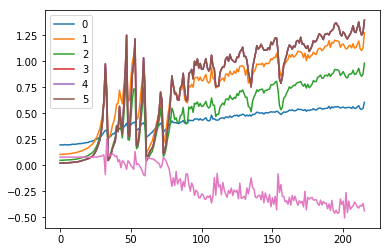

In [22]:
for l in model.act_means: plt.plot(l)
plt.legend(range(6));

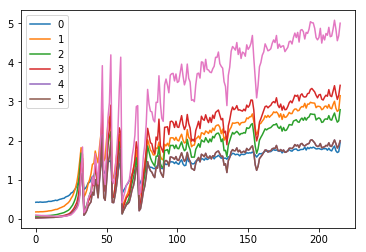

In [23]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6));

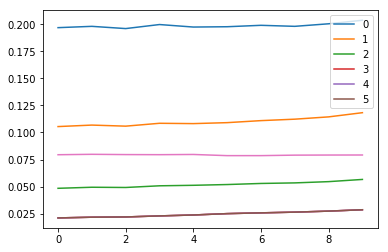

In [24]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(6));

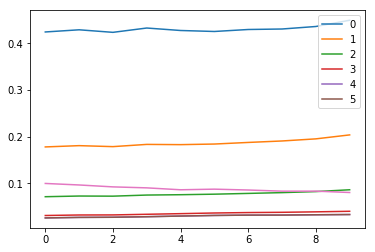

In [25]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(6));

# Hooks

In [11]:
model =  SequentialModel(*get_cnn_layers(data, nfs))
learn = get_learner(model, data, lr=0.4, cbs=cbfs)

NameError: name 'SequentialModel' is not defined

In [28]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

In [29]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds [i].append(outp.data.std())

In [33]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

In [34]:
learn.fit(1)

train: [2.01049390625, tensor(0.3106)]
valid: [1.171196875, tensor(0.5884)]


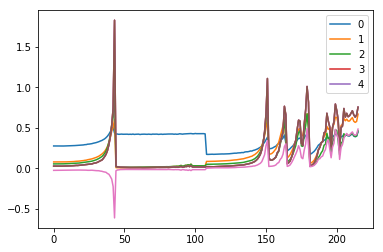

In [36]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

# Hooks

In [79]:
model = get_cnn_model(data, nfs)
learn = get_learner(model, data, lr=0.5, cbs=cbfs)

In [27]:
hooks = Hooks(model, append_stats)

In [28]:
hooks

Hooks (7 items)
[<pylite.core.Hook object at 0x00000226667428D0>, <pylite.core.Hook object at 0x0000022666742C50>, <pylite.core.Hook object at 0x0000022666742AC8>, <pylite.core.Hook object at 0x0000022666742668>, <pylite.core.Hook object at 0x0000022666742470>, <pylite.core.Hook object at 0x0000022666786198>, <pylite.core.Hook object at 0x0000022666786588>]

In [29]:
hooks.remove()

In [36]:
x,y = next(iter(data.train_dl))
x = mnist_resize(x)

In [37]:
x.mean(),x.std()

(tensor(-0.0009), tensor(0.9980))

In [42]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.1446, grad_fn=<MeanBackward0>),
 tensor(0.2194, grad_fn=<StdBackward0>))

In [53]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [44]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.4916, grad_fn=<MeanBackward0>),
 tensor(0.8998, grad_fn=<StdBackward0>))

In [72]:
for m in model: print(m)

Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): ReLU()
)
Sequential(
  (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)
Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)
Sequential(
  (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)
AdaptiveAvgPool2d(output_size=1)
Lambda()
Linear(in_features=32, out_features=10, bias=True)


In [78]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    means,stds = hook.stats
    means.append(outp.data.mean())
    stds .append(outp.data.std())

train: [0.2035617578125, tensor(0.9388)]
valid: [0.126630615234375, tensor(0.9614)]
train: [0.105753564453125, tensor(0.9678)]
valid: [0.093460693359375, tensor(0.9716)]


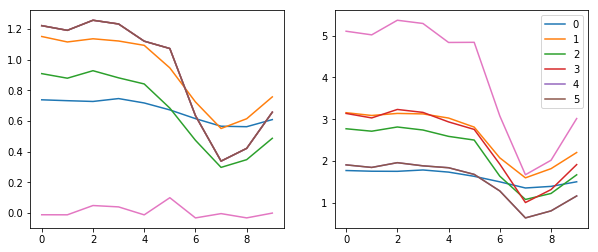

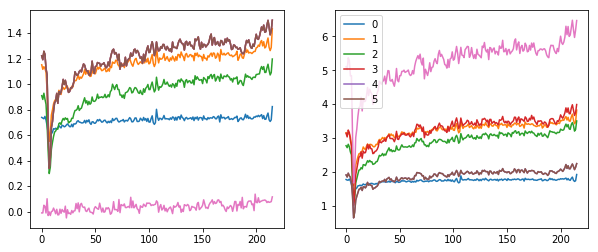

In [82]:
with Hooks(model, append_stats) as hooks:
    learn.fit(2)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));

# Other statistics using histograms

In [9]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,0,10)) #histc isn't implemented on the GPU

In [10]:
model = get_cnn_model(data, nfs)
learn = get_learner(model, data, lr=0.9, cbs=cbfs)

In [11]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [13]:
with Hooks(model, append_stats) as hooks: learn.fit(1)

train: [1.14146671875, tensor(0.6148)]
valid: [0.20033104248046876, tensor(0.9396)]


In [14]:
hooks

Hooks (7 items)
[<pylite.core.Hook object at 0x0000020BE7B10C88>, <pylite.core.Hook object at 0x0000020BE7B10A90>, <pylite.core.Hook object at 0x0000020BE7B10CF8>, <pylite.core.Hook object at 0x0000020BE7B102E8>, <pylite.core.Hook object at 0x0000020BE7B10240>, <pylite.core.Hook object at 0x0000020BE7B10860>, <pylite.core.Hook object at 0x0000020BE7B10208>]

In [15]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

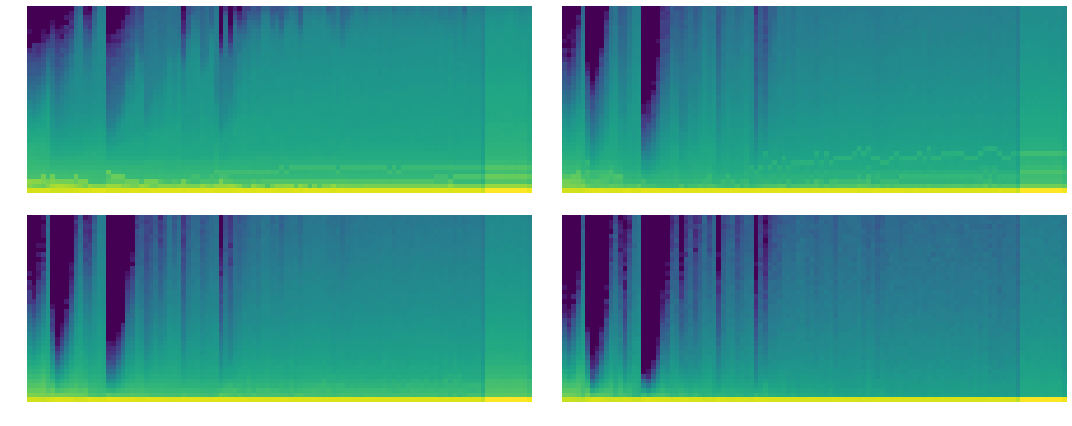

In [16]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [17]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/h1.sum(0)

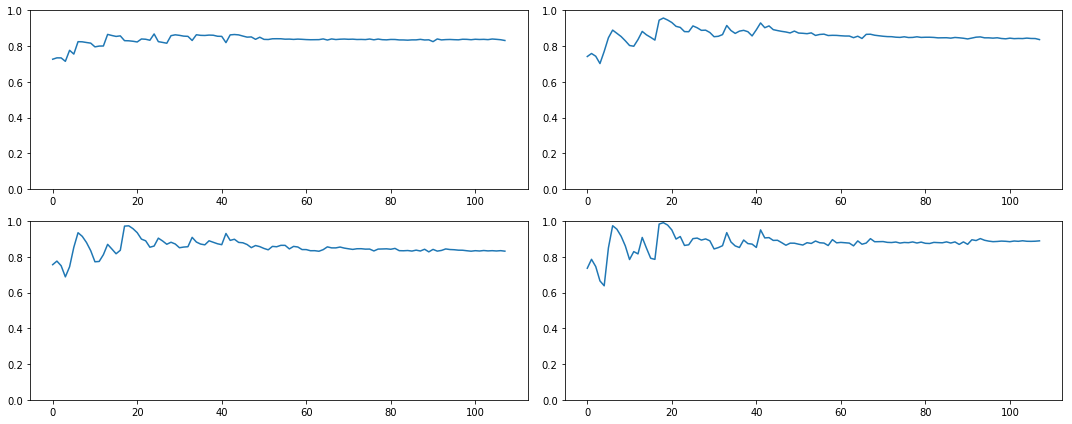

In [18]:
torch.Tensor.ndim = property(lambda x: len(x.shape))
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()